# Import e funzioni 

In [31]:
!pip install geopandas
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
from tqdm import tqdm
import geopandas as gpd
import geopandas as gpd
from shapely.geometry import Point
from shapely.ops import transform
import pyproj
import pandas as pd
import geopandas as gpd
import numpy as np
from shapely.geometry import Point
import os

# Convertire miglia nautiche in gradi (approssimazione)
def miles_to_degrees(miles):
    return miles / 60.0

radius_degrees = miles_to_degrees(10)  # raggio di 10 miglia nautiche

# Funzione per creare un cerchio attorno a un punto
def create_circle_around_point(point, radius):
    return point.buffer(radius)

# read dati

In [34]:
ais=pd.read_csv('/kaggle/input/ais-tesi/2022_5386954_emissions_hourly.csv',low_memory=False).reset_index(drop=False) 
ports=pd.read_csv('/kaggle/working/best_centroids.csv')
ports.columns=['Unnamed: 0', 'PORT_CODE', 'LONGITUDE', 'LATITUDE']

# Accorpamento dei centroidi vicini

In [35]:
import geopandas as gpd
import numpy as np
from sklearn.cluster import DBSCAN
from shapely.geometry import Point

# Supponiamo che df sia il tuo GeoDataFrame con punti dei porti
df = ports

import pandas as pd
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler

# Supponiamo che 'df' sia il tuo DataFrame
# Seleziona le colonne delle coordinate
coordinates = df[['LONGITUDE', 'LATITUDE']]

# Standardizza i dati
scaler = StandardScaler()
scaled_coordinates = scaler.fit_transform(coordinates)

# Crea e applica l'algoritmo DBSCAN
db = DBSCAN(eps=0.1, min_samples=1).fit(scaled_coordinates)

# Aggiungi i cluster al DataFrame
df['cluster'] = db.labels_

# Trova i cluster unici
clusters = df['cluster'].unique()

# Campiona un punto per ogni cluster
ports = df.groupby('cluster').apply(lambda x: x.sample(1)).reset_index(drop=True)



/tmp/ipykernel_36/96664247.py:31: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  ports = df.groupby('cluster').apply(lambda x: x.sample(1)).reset_index(drop=True)


# Trasformiamo i dataset in geopandas

In [36]:
# Leggi il dataframe dei porti e trasformalo in geopandas e crea cerchio
ports=ports[['PORT_CODE','LONGITUDE','LATITUDE']].copy()
ports['geometry'] = ports.apply(lambda row: Point(row['LONGITUDE'], row['LATITUDE']), axis=1)
ports_gdf = gpd.GeoDataFrame(ports, geometry='geometry')
ports_gdf['geometry'] = ports_gdf['geometry'].apply(lambda point: create_circle_around_point(point, radius_degrees))
ports_gdf.crs = "EPSG:4326"
ports_gdf['PORT_CODE'] = ports_gdf['PORT_CODE'].astype(str)



# Leggi il dataframe dei AIS e trasformalo in geopandas, fai il join con i porti e ritorna una lista dei viaggi 
ais=pd.read_csv('/kaggle/input/ais-tesi/2022_5386954_emissions_hourly.csv',low_memory=False).reset_index(drop=False)
imo=ais['IMO']
ais=ais[['index', 'LONGITUDE','LATITUDE','SOG']].copy()
ais['geometry'] = ais.apply(lambda row: Point(row['LONGITUDE'], row['LATITUDE']), axis=1)
ais_gdf = gpd.GeoDataFrame(ais, geometry='geometry')
ais_gdf.crs = "EPSG:4326"  

# Ora che sono tutti geopandas possiamo fare il join per vedere ogni segnale rispetto a ogni porto
intersections = gpd.sjoin(ais_gdf, ports_gdf, how='left', predicate='intersects')
intersections_cleaned = intersections.drop_duplicates(subset=['index'])
intersections_cleaned.loc[intersections_cleaned['SOG'] > 3, 'PORT_CODE'] = 'move'
intersections_cleaned['PORT_CODE'] = intersections_cleaned['PORT_CODE'].fillna('unknown')

 

/opt/conda/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:131: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)
/opt/conda/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:131: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


In [37]:

result = []
for code in intersections_cleaned['PORT_CODE']:
    if code != 'move':
        # Aggiungi il codice se non è già l'ultimo aggiunto
        if not result or result[-1] != code:
            result.append(code)
arcs = [(result[i], result[i + 1]) for i in range(len(result) - 1)]
filtered_arcs = [(source, destination) for source, destination in arcs if source != 'unknown' and destination != 'unknown']
filtered_arcs

[('2', '22'),
 ('22', '2'),
 ('2', '22'),
 ('22', '2'),
 ('2', '22'),
 ('22', '7'),
 ('7', '2'),
 ('2', '7'),
 ('7', '14'),
 ('14', '23'),
 ('23', '20'),
 ('20', '14'),
 ('20', '14'),
 ('14', '20'),
 ('14', '20'),
 ('20', '14'),
 ('14', '23'),
 ('23', '20'),
 ('20', '14'),
 ('14', '20'),
 ('20', '14'),
 ('14', '3')]

In [38]:
intersections_cleaned.to_csv('/kaggle/working/intersections_cleaned.csv')

# da ogni ais accoppia porti, e definisce i viaggi


In [82]:
# Leggi il dataframe dei porti e trasformalo in geopandas e crea cerchio
ports=ports[['PORT_CODE','LONGITUDE','LATITUDE']].copy()
ports['geometry'] = ports.apply(lambda row: Point(row['LONGITUDE'], row['LATITUDE']), axis=1)
ports_gdf = gpd.GeoDataFrame(ports, geometry='geometry')
ports_gdf['geometry'] = ports_gdf['geometry'].apply(lambda point: create_circle_around_point(point, radius_degrees))
ports_gdf.crs = "EPSG:4326"
ports_gdf['PORT_CODE'] = ports_gdf['PORT_CODE'].astype(str)


directory = '/kaggle/input/ais-tesi'
data = []

for file_name in tqdm(os.listdir(directory)):
    if file_name.endswith('.csv'):
        # Leggi il dataframe dei AIS e trasformalo in geopandas,
        file_path = os.path.join(directory, file_name)
        ais = pd.read_csv(file_path, low_memory=False).reset_index(drop=False)
        imo = file_name.split('_')[1]
        ais=ais[['index', 'LONGITUDE','LATITUDE','SOG']].copy()
        ais['geometry'] = ais.apply(lambda row: Point(row['LONGITUDE'], row['LATITUDE']), axis=1)
        ais_gdf = gpd.GeoDataFrame(ais, geometry='geometry')
        ais_gdf.crs = "EPSG:4326" 
        # Ora che sono tutti geopandas possiamo fare il join per vedere ogni segnale rispetto a ogni porto
        intersections = gpd.sjoin(ais_gdf, ports_gdf, how='left', predicate='intersects')
        intersections_cleaned = intersections.drop_duplicates(subset=['index'])
        intersections_cleaned.loc[intersections_cleaned['SOG'] > 3, 'PORT_CODE'] = 'move'
        intersections_cleaned['PORT_CODE'] = intersections_cleaned['PORT_CODE'].fillna('unknown')
        result = []
        for code in intersections_cleaned['PORT_CODE']:
            if code != 'move':
                # Aggiungi il codice se non è già l'ultimo aggiunto
                if not result or result[-1] != code:
                    result.append(code)
        arcs = [(result[i], result[i + 1]) for i in range(len(result) - 1)]
        filtered_arcs = [(source, destination) for source, destination in arcs if source != 'unknown' and destination != 'unknown']
        for source, destination in filtered_arcs:
            data.append({'IMO': imo, 'Source': source, 'Destination': destination})
archi = pd.DataFrame(data)
archi=archi.groupby(['Source','Destination']).count().reset_index()
archi.columns=['Source', 'Target', 'Weight']
archi['Source'] = archi['Source'].astype(str)
archi.to_csv('archi.csv', index=False)
ports.to_csv('ports.csv', index=False)

/opt/conda/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:131: ShapelyDeprecationWarning:

The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.

  0%|          | 0/126 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:131: ShapelyDeprecationWarning:

The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.

  1%|          | 1/126 [00:01<03:34,  1.71s/it]/opt/conda/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:131: ShapelyDeprecationWarning:

The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.

  2%|▏         | 2/126 [00:03<03:34,  1.73s/it]/opt/conda/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:131: ShapelyDeprecationWarning:

The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to

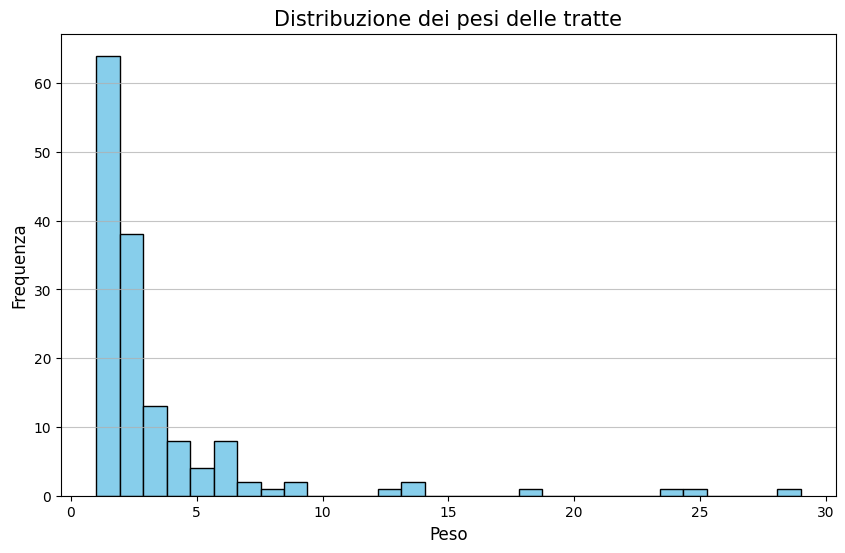

In [92]:
import pandas as pd
import matplotlib.pyplot as plt

# Carica il dataframe archi
archi = pd.read_csv('archi.csv')  # Assicurati che il file CSV sia nella stessa directory o fornisci il percorso corretto

# Crea un istogramma dei pesi
plt.figure(figsize=(10, 6))
plt.hist(archi['Weight'], bins=30, color='skyblue', edgecolor='black')

# Aggiungi titoli e etichette
plt.title('Distribuzione dei pesi delle tratte', fontsize=15)
plt.xlabel('Peso', fontsize=12)
plt.ylabel('Frequenza', fontsize=12)

# Mostra la griglia per facilitare la lettura
plt.grid(axis='y', alpha=0.75)

# Mostra il grafico
plt.show()


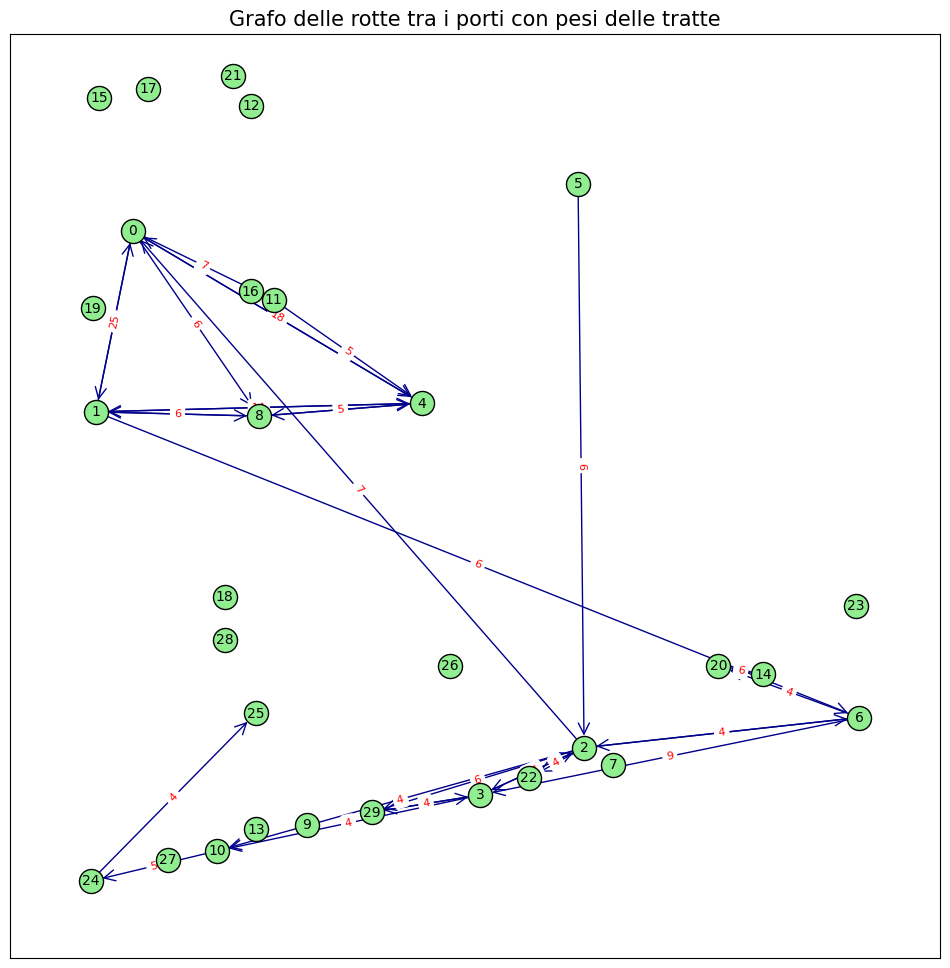

In [94]:
import pandas as pd
import geopandas as gpd
import networkx as nx
import matplotlib.pyplot as plt

# Leggi i dati dai file CSV
ports = pd.read_csv('ports.csv')  # Nodi
archi = pd.read_csv('archi.csv')  # Archi con pesi
archi=archi[archi['Weight']>3]
# Crea il grafo
G = nx.DiGraph()

# Aggiungi i nodi al grafo con attributi
for index, row in ports.iterrows():
    G.add_node(row['PORT_CODE'], pos=(row['LONGITUDE'], row['LATITUDE']))

# Aggiungi gli archi al grafo con pesi
for index, row in archi.iterrows():
    G.add_edge(row['Source'], row['Target'], weight=row['Weight'])

# Disegna il grafo
plt.figure(figsize=(12, 12))

# Ottieni le posizioni dei nodi dal grafo
pos = nx.get_node_attributes(G, 'pos')

# Modifica il colore dei nodi e degli archi per migliorare la leggibilità
# Disegna i nodi con un colore chiaro
nx.draw_networkx_nodes(G, pos, node_size=300, node_color='lightgreen', edgecolors='black')

# Disegna gli archi con un colore più scuro e frecce grandi
nx.draw_networkx_edges(G, pos, arrowstyle='->', arrowsize=20, edge_color='darkblue')

# Aggiungi etichette ai nodi (PORT_CODE) con un font scuro
nx.draw_networkx_labels(G, pos, font_size=10, font_color='black')

# Estrai i pesi degli archi
edge_labels = {(row['Source'], row['Target']): row['Weight'] for index, row in archi.iterrows()}

# Disegna le etichette dei pesi sugli archi con un colore rosso per evidenziare
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='red', font_size=8)

# Imposta il titolo
plt.title("Grafo delle rotte tra i porti con pesi delle tratte", fontsize=15)
plt.show()


In [81]:
ports

,PORT_CODE,LONGITUDE,LATITUDE,geometry
0,0,-5.863281,54.65625,POINT (-5.86328125 54.65625)
1,1,-6.226562,53.34375,POINT (-6.2265625 53.34375)
2,2,-1.401367,50.90625,POINT (-1.4013671875 50.90625)
3,3,-2.427734,50.56250,POINT (-2.427734375 50.5625)
4,4,-3.005859,53.40625,POINT (-3.005859375 53.40625)
5,5,-1.460938,55.00000,POINT (-1.4609375 55)
6,6,1.318359,51.12500,POINT (1.318359375 51.125)
7,7,-1.111393,50.78125,POINT (-1.1113932291666666 50.78125)
8,8,-4.613281,53.31250,POINT (-4.61328125 53.3125)
9,9,-4.140625,50.34375,POINT (-4.140625 50.34375)


# top 10 nodi 

In [90]:
import pandas as pd
import networkx as nx

# Supponiamo che 'df_viaggi' e 'G' siano già definiti

# Calcola il grado di ogni nodo
degree_sequence = G.degree()  # Restituisce una lista di tuple (nodo, grado)

# Ordina i nodi in base al grado in modo decrescente
sorted_nodes = sorted(degree_sequence, key=lambda x: x[1], reverse=True)

# Se vuoi i primi N nodi con grado maggiore (per esempio, i primi 10)
N = 10
top_nodes = sorted_nodes[:N]

# Crea un DataFrame per visualizzare i nodi e i loro gradi
top_nodes_df = pd.DataFrame(top_nodes, columns=['Nodo', 'Grado'])

print(top_nodes_df)

ports[ports['PORT_CODE']==27]

   Nodo  Grado
0     2     24
1     1     23
2     0     22
3     6     21
4     4     20
5     3     19
6     7     19
7    24     18
8    10     16
9    14     13


,PORT_CODE,LONGITUDE,LATITUDE,geometry
27,27,-5.515625,50.09375,POINT (-5.515625 50.09375)


# distribuzione del grado dei nodi

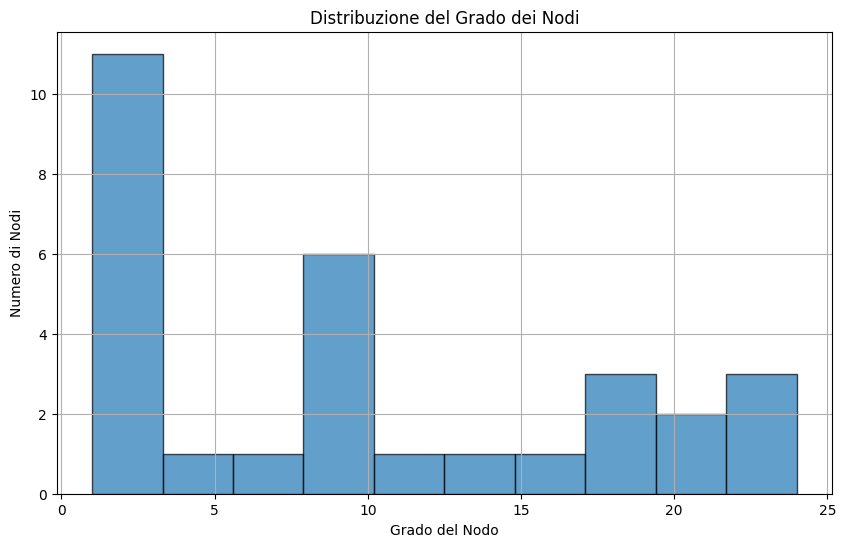

In [48]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

# Supponiamo che 'df_viaggi' e 'G' siano già definiti

# Calcola il grado dei nodi
degree_sequence = [G.degree(n) for n in G.nodes()]
degrees = degree_sequence  # Gradi dei nodi

# Crea un istogramma della distribuzione dei gradi
plt.figure(figsize=(10, 6))
plt.hist(degrees, edgecolor='black', alpha=0.7)
plt.title('Distribuzione del Grado dei Nodi')
plt.xlabel('Grado del Nodo')
plt.ylabel('Numero di Nodi')
plt.grid(True)
plt.show()


In [167]:
ports[ports['PORT_CODE']==196]

,PORT_CODE,LONGITUDE,LATITUDE,geometry
1,196,0.435791,53.59375,POINT (0.435791015625 53.59375)


# Esporto in formato SHAPE

In [164]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point

ais
# Convertire il DataFrame in geometrie di punti
geometry = [Point(xy) for xy in zip(ais['LONGITUDE'], ais['LATITUDE'])]

# Creare un GeoDataFrame
gdf = gpd.GeoDataFrame(ais, geometry=geometry)

# Impostare un sistema di riferimento spaziale (SRID), ad esempio WGS84
gdf.crs = "EPSG:4326"

# Esportare come shapefile
gdf.to_file('output_shapefile.shp')
